# Digital Marketing Channel Attribution Models 

## Introduction:

The key strength of digital marketing lies in the the abilities to measure their customer journey and identify how the different channels were resonated with their customers.  Within the context of E-commerce, we could use the information to understand which path our customers comes through before they purchase the products on your site or sign up for your memberships.  Since Google and Facebook is gradually shifting more traffic to their paid channles, it is essential for any business to build differnet models on their marketing attributions.  

In this marketing-attribution project, we will apply following models:
* Rule Based: Last-Click, Time Decay
* Data-Driven Models:
  * Shapley Value Models - (Google Analytics is using Shapley Value, However, there is an limitation based on minimum conversions.)
  * Markov Chain


It's remarkbale to think that old-fashioned marketing attribution models until recently that was rule-based is now adopting data-driven models by data analyst across different industry. However, Nothing is perfect and even google analytics data-drive models have a limitations on [minimum conversions](https://support.google.com/analytics/answer/3070276?hl=en). 

In this project, we will go through rule-based marketing attribution models first and then move on to shapley value model and and markov chain model. We will use the sample marketing data from [Kaggle](https://www.kaggle.com/kavitabhagwani/marketing-campaign). This dataset is the most straight-forward dataset that I came across and we wouldn't spend too much time on data manipulation in this project. For more data cleaning teachniques, check out my [data cleaning project](https://github.com/Viktorjin/Python-Data-Projects/tree/master/Data-Cleaning-Projects).

## Import Data and Select Relevent Columns

In [1]:
import numpy as np
import pandas as pd
data = pd.read_csv('marketing.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10037 entries, 0 to 10036
Data columns (total 12 columns):
user_id                10037 non-null object
date_served            10021 non-null object
marketing_channel      10022 non-null object
variant                10037 non-null object
converted              10022 non-null object
language_displayed     10037 non-null object
language_preferred     10037 non-null object
age_group              10037 non-null object
date_subscribed        1856 non-null object
date_canceled          577 non-null object
subscribing_channel    1856 non-null object
is_retained            1856 non-null object
dtypes: object(12)
memory usage: 941.1+ KB


In [2]:
data.head()

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained
0,a100000029,1/1/18,House Ads,personalization,True,English,English,0-18 years,1/1/18,NaN,House Ads,True
1,a100000030,1/1/18,House Ads,personalization,True,English,English,19-24 years,1/1/18,NaN,House Ads,True
2,a100000031,1/1/18,House Ads,personalization,True,English,English,24-30 years,1/1/18,NaN,House Ads,True
3,a100000032,1/1/18,House Ads,personalization,True,English,English,30-36 years,1/1/18,NaN,House Ads,True
4,a100000033,1/1/18,House Ads,personalization,True,English,English,36-45 years,1/1/18,NaN,House Ads,True


In [3]:
# creating 'conversion' column with lambda function
data['conversion'] = data['converted'].apply(lambda x: 1 if x == True else 0)
print(data.head())

      user_id date_served marketing_channel          variant converted  \
0  a100000029      1/1/18         House Ads  personalization      True   
1  a100000030      1/1/18         House Ads  personalization      True   
2  a100000031      1/1/18         House Ads  personalization      True   
3  a100000032      1/1/18         House Ads  personalization      True   
4  a100000033      1/1/18         House Ads  personalization      True   

  language_displayed language_preferred    age_group date_subscribed  \
0            English            English   0-18 years          1/1/18   
1            English            English  19-24 years          1/1/18   
2            English            English  24-30 years          1/1/18   
3            English            English  30-36 years          1/1/18   
4            English            English  36-45 years          1/1/18   

  date_canceled subscribing_channel is_retained  conversion  
0           NaN           House Ads        True           1 

In [4]:
# selecting relevent columns for marketing attribution model
Marketing_data = data.loc[:,['user_id','date_served','marketing_channel','variant','subscribing_channel','converted','conversion']]
Marketing_data.head()

,user_id,date_served,marketing_channel,variant,subscribing_channel,converted,conversion
0,a100000029,1/1/18,House Ads,personalization,House Ads,True,1
1,a100000030,1/1/18,House Ads,personalization,House Ads,True,1
2,a100000031,1/1/18,House Ads,personalization,House Ads,True,1
3,a100000032,1/1/18,House Ads,personalization,House Ads,True,1
4,a100000033,1/1/18,House Ads,personalization,House Ads,True,1


In [5]:
Marketing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10037 entries, 0 to 10036
Data columns (total 7 columns):
user_id                10037 non-null object
date_served            10021 non-null object
marketing_channel      10022 non-null object
variant                10037 non-null object
subscribing_channel    1856 non-null object
converted              10022 non-null object
conversion             10037 non-null int64
dtypes: int64(1), object(6)
memory usage: 549.0+ KB


In [6]:
# Drop the Null values in user_id, date_served,etc. 
Marketing_data.dropna(axis=0,inplace=True)
Marketing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1856 entries, 0 to 10036
Data columns (total 7 columns):
user_id                1856 non-null object
date_served            1856 non-null object
marketing_channel      1856 non-null object
variant                1856 non-null object
subscribing_channel    1856 non-null object
converted              1856 non-null object
conversion             1856 non-null int64
dtypes: int64(1), object(6)
memory usage: 116.0+ KB


## Rule-Based Methods:

An rule-based attribution is using a set of rules that determines how credit/conversion is assigned to different marketing channels in the conversion paths. For example, the last-click attribution model assigns 100% credit to the final touchpoint. It is far to say that rule-based attriution model is defined by human, and as a result, it's subjective and can be biased towards certain business model. 

However, If you only have limited exposure of your marketing data and wants an simple attribution model, it's much easier to use rule-based attribution model.  In this section, I will use Python based on marketing_attribution_models developed by Andre Tocci. you can find more information [here](https://github.com/DP6/Marketing-Attribution-Models)

In [7]:
# Import class and creating MAM object
from marketing_attribution_models import MAM

# Setting the parameters, group_chennels = True if each row in the dataframe is a session of the user's journey. 
attributions = MAM(Marketing_data, 
                   group_channels = True, 
                   channels_colname="marketing_channel",
                   journey_with_conv_colname = 'converted',
                   group_channels_by_id_list = ['user_id'],
                   group_timestamp_colname = 'date_served',
                   create_journey_id_based_on_conversion = True
                  )

attributions. DataFrame

,journey_id,channels_agg,converted_agg,conversion_value,time_till_conv_agg
0,id:a100000029_J:0,House Ads,True,1,0.0
1,id:a100000030_J:0,House Ads,True,1,0.0
2,id:a100000031_J:0,House Ads,True,1,0.0
3,id:a100000032_J:0,House Ads,True,1,0.0
4,id:a100000033_J:0,House Ads,True,1,0.0
...,...,...,...,...,...
1272,id:a100007290_J:0,Email,True,1,0.0
1273,id:a100007291_J:0,Email,True,1,0.0
1274,id:a100007292_J:0,Instagram,False,0,0.0
1275,id:a100007293_J:0,Email,True,1,0.0


In the above table, we imported marketing data into the MAM object. Our marketing channels were grouped based on their user_id and converted columns. (please refer back to how we are setting the parameters wihtin the MAM).  Note: journey_id was generated based on user_id and converted column and serve as the unique identifier. 

It is worth noting that it seems like channles_agg column from the table aboved only possess single marketing channels. but the reality is far more complex. We will explore the combinations of different marketing channels within customer's purchase journey in the next part: 

Here are some examples of marketing channels combination:
* 'Push > House Ads 
* 'House Ads > House Ads > Push > Push > House Ads > House Ads > Facebook',
* 'House Ads > House Ads > Email > Email > House Ads > House Ads > House Ads > House Ads > Email'

In [8]:
# Unique Marketing Channels Combinations
channels_subset=attributions. DataFrame
channels_subset["channels_agg"].unique() 

array(['House Ads', 'House Ads > House Ads', 'Push > House Ads',
       'Facebook > House Ads', 'Instagram > House Ads', 'Email', 'Push',
       'Facebook', 'Instagram', 'Instagram > Email', 'Facebook > Email',
       'House Ads > Facebook', 'House Ads > Instagram',
       'House Ads > Email', 'House Ads > Push', 'Push > Facebook',
       'Facebook > Instagram', 'Instagram > Push', 'Instagram > Facebook',
       'Instagram > Instagram', 'Push > Email', 'Facebook > Push',
       'House Ads > Facebook > House Ads > House Ads > Email',
       'House Ads > House Ads > House Ads > House Ads > Push',
       'House Ads > House Ads > House Ads > House Ads > Facebook',
       'House Ads > Push > House Ads > House Ads > Instagram',
       'House Ads > Facebook > House Ads > Instagram',
       'House Ads > Instagram > House Ads > Instagram',
       'House Ads > House Ads > Push',
       'House Ads > House Ads > House Ads > House Ads > Instagram',
       'House Ads > House Ads > House Ads > House 

In [9]:
# Adopting Last Click Attribution Model
attributions. attribution_last_click()
# A column with given attribution model will be added at the end of the table. 
attributions . DataFrame

,journey_id,channels_agg,converted_agg,conversion_value,time_till_conv_agg,attribution_last_click_heuristic
0,id:a100000029_J:0,House Ads,True,1,0.0,1
1,id:a100000030_J:0,House Ads,True,1,0.0,1
2,id:a100000031_J:0,House Ads,True,1,0.0,1
3,id:a100000032_J:0,House Ads,True,1,0.0,1
4,id:a100000033_J:0,House Ads,True,1,0.0,1
...,...,...,...,...,...,...
1272,id:a100007290_J:0,Email,True,1,0.0,1
1273,id:a100007291_J:0,Email,True,1,0.0,1
1274,id:a100007292_J:0,Instagram,False,0,0.0,0
1275,id:a100007293_J:0,Email,True,1,0.0,1


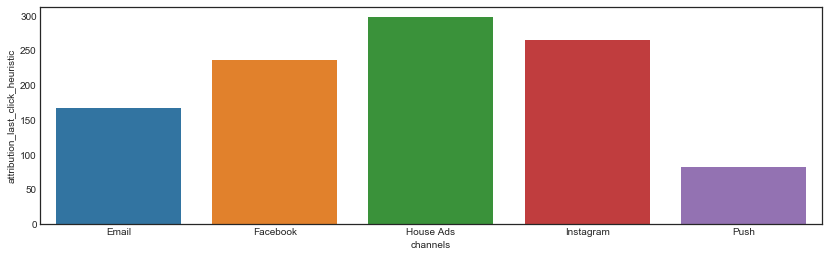

In [10]:
#Prep data for the bar chart
last_click_attribution_reasults = attributions . group_by_channels_models

#Import Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.subplots(figsize=(14,4))
sns.barplot(x='channels', y='attribution_last_click_heuristic', data=last_click_attribution_reasults)
plt.show()

# Data Driven Model - Shapley Value

The shapley value was developed by Economics Science winner Lloyd S. Shapley. Cooperative game theory and the shapley value provides a way to measure the contribution of each marketing channels. The basic idea of Shapley value method is that it takes the weighted average of its marginal contribution over all possible coalitions for each channel. In other words, shapley value provides an effective way to measure channel influence and divide the credit fairly across marketing channels. 

In order to better implement Shapley Value attribution model, we also need to understand the **limitations of the Shapley value attribution model:** 
* The Shapley Value is based on combinatory mathematics, and the number of possible coalitions and ordered sequences becomes huge when the number of campaigns increases.
* Channels rarely present or present in long journeys will be played down.
* If unordered, the Shapley Value assumes the contribution of campaign A is the same if followed by campaign B or by C.
* In the marketing context a journey with a high number of channels will not necessarily bring more orders than a journey with less channels involved.

In our package, the default size of marketing channels is 4.  This size parameter set an limitation on the number of unique channels in each customer's purchase journey. We need to be careful with the default channel size setting because the number of possible coaliation of marketing channels increases exponentially with the number of channels. 

In [11]:
attributions . attribution_shapley()
attributions.group_by_channels_models

,channels,attribution_last_click_heuristic,attribution_shapley_size4_conv_rate_algorithmic
0,Email,167,149.251648
1,Facebook,237,211.528757
2,House Ads,298,401.331657
3,Instagram,265,214.678791
4,Push,83,73.209146


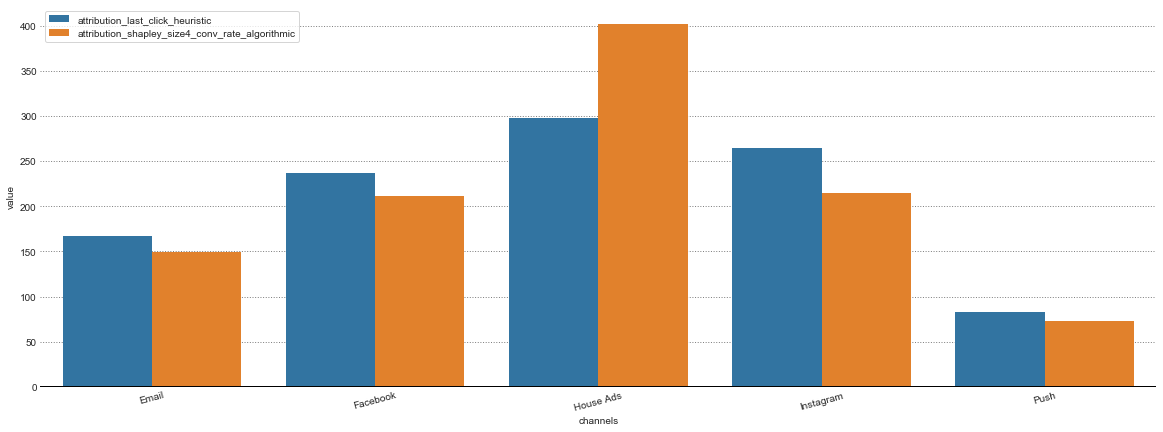

In [12]:
# Compare the distribution between last click model attribution and Shapley Value. 
attributions.plot()
plt.show()

# Data Driven Model - Markov Chains

Markov chains is a model describing a sequence of pssoble events in which the probability of each event depends only on the state attained in the previous event. in the marketing context, Markov chains model provide a way to model conversion funnel. 
In this model, there are two main components need to be cacualted: 
* Transition probabilities between all states 
* Removal effect of each channels (difference in pobabaility in conversions if one channel is removed) 

We won't go too deep into the Markov chains theory in this article, but if you are intersted to learn more this model. [Setosa.io](https://setosa.io/ev/markov-chains/) is a good place. 

**There serveral benefits to adopt Markov Chains Model:** 
  * Dynamic Journey is taken into account
  * It is possible to build a conversion path that maps customer journey. 

**However, This model also has its own limitations:**

* It can be somewhat difficult to set the memory parameter. If we set this parameter too high will lead to over-sensitivity to noise. ( memory parameter: The number of previous steps that are taken into account to model the transition probability is called the memory parameter of the sequence, and for the model to have a solution must be comprised between 0 and 4.)

* Long journeys with different channels involved will be overweighted, as they will count many times in the Removal Effect. 




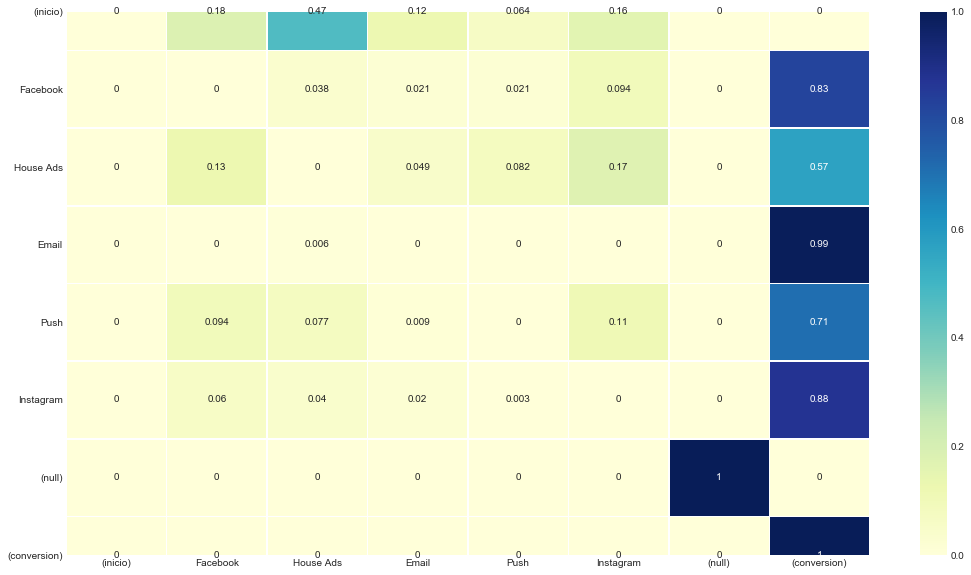

In [13]:
attribution_markov = attributions . attribution_markov ( transition_to_same_state = False )

# Generating the transition matrix 
ax,fig  =  plt.subplots ( figsize = ( 18 , 10 )) 
sns.heatmap(attribution_markov[2].round(3), cmap="YlGnBu", annot=True , linewidths =.5 )
plt.yticks(rotation=0)

plt.show()

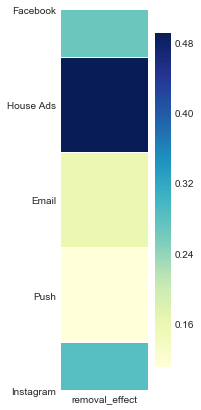

In [17]:
# Removal Effect
x,fig = plt.subplots ( figsize = (2,7)) 
sns.heatmap ( attribution_markov[3] . round (3),  cmap = "YlGnBu",  annot = False,  linewidths =.5 )
plt.yticks(rotation=0)
plt.show()

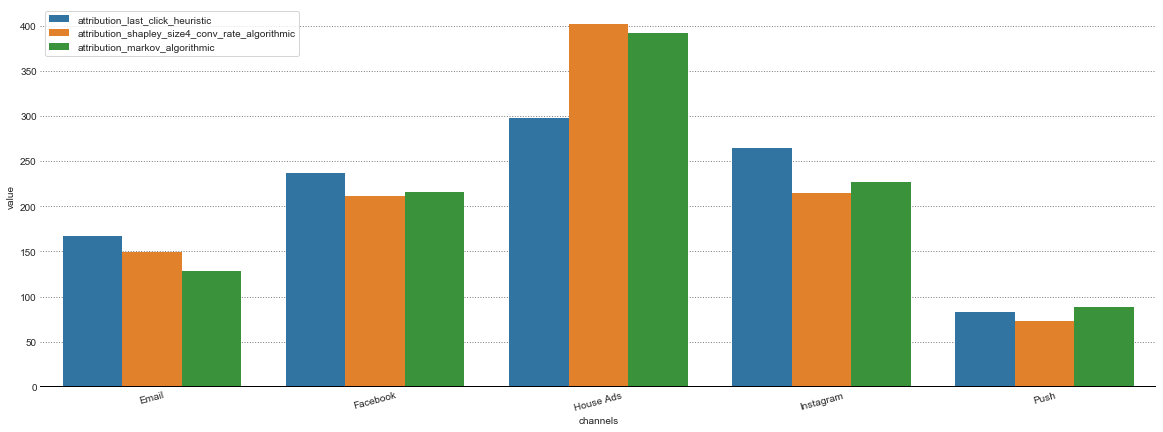

In [18]:
#Visulization - Comparation of Three Different Attribution Models
attributions.plot()
plt.show()

# Conclusion:
To summarize, the results shows house ads is vital to our marketing campaigns based on our sample data. If we adopt the data-drive method, I could recommend allocate more resource into the house ads. (For example, If the sample data generated from a Ecommerce business, house ads could be the ads served on the e-commerce platform which will attract customers with strong purchase motivation.) 

Each marketing attribution model has its own unique strengh and limitation. so Which method should we use? 

... It really depends on your business >>>>

**Shapley Value method**
* Wider industry adoption
* More straightfoward to the attribution problem which do not take sequence into consideration.
* A cooperative Game Theory (All the marketing channels contribute to the total payoff) 

**Markov chain method**
* It considers channel sequence as a fundamental part of the model which is similar to a customer's purchase journey. 
